In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import np_utils
import keras as K

Using TensorFlow backend.


#### 数据准备

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./tmp/data/", one_hot=True) # 已经归一化处理

Extracting ./tmp/data/train-images-idx3-ubyte.gz
Extracting ./tmp/data/train-labels-idx1-ubyte.gz
Extracting ./tmp/data/t10k-images-idx3-ubyte.gz
Extracting ./tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
X_train, y_train = mnist.train.images, mnist.train.labels
X_valid, y_valid = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(55000, 784) (55000, 10)
(5000, 784) (5000, 10)
(10000, 784) (10000, 10)


#### 展示几张图片

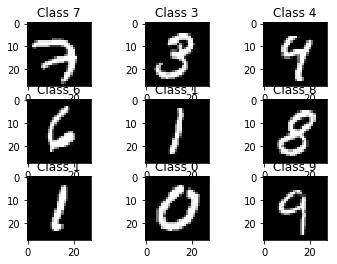

In [8]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(mnist.train.images[i].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Class {}".format(mnist.train.labels[i]))

#### 构建模型

In [4]:
def MLP(lr):
    model = Sequential()

    model.add(Dense(784, input_shape=(784,), kernel_initializer='he_normal'))
    model.add(Activation('relu'))
    # model.add(Dropout(0.2)) 

    model.add(Dense(784, kernel_initializer='he_normal'))
    model.add(Activation('relu'))
    # model.add(Dropout(0.2)) 

    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(optimizer=K.optimizers.SGD(lr=lr),loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### sgd

In [5]:
from swa import LearningRateDisplay
training_epochs = 20
batch_size = 100
lr = 0.05
model_sgd = MLP(lr)
lr_display_obj = LearningRateDisplay()
model_sgd.fit(X_train, y_train, validation_data=(X_valid, y_valid),callbacks=[lr_display_obj], epochs=training_epochs, batch_size=batch_size)

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
learning rate of current epoch is : 0.05000000074505806
55000/55000 [==============================] - 17s 302us/step - loss: 0.4361 - acc: 0.8825 - val_loss: 0.2476 - val_acc: 0.9302
Epoch 2/20
learning rate of current epoch is : 0.05000000074505806
55000/55000 [==============================] - 9s 168us/step - loss: 0.2202 - acc: 0.9376 - val_loss: 0.1769 - val_acc: 0.9518
Epoch 3/20
learning rate of current epoch is : 0.05000000074505806
55000/55000 [==============================] - 9s 169us/step - loss: 0.1684 - acc: 0.9521 - val_loss: 0.1462 - val_acc: 0.9602
Epoch 4/20
learning rate of current epoch is : 0.05000000074505806
55000/55000 [==============================] - 9s 161us/step - loss: 0.1367 - acc: 0.9611 - val_loss: 0.1249 - val_acc: 0.9662
Epoch 5/20
learning rate of current epoch is : 0.05000000074505806
55000/55000 [==============================] - 9s 160us/step - loss: 0.1149 - acc: 0.9678 - val_loss: 0.110

In [7]:
# 测试结果
loss, accuracy = model_sgd.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Accuracy:', accuracy)

10000/10000 [==============================] - 1s 143us/step
Test loss: 0.0648167538861
Accuracy: 0.9808


## swa
三种学习率策略  
![](./img/lr.png)

In [17]:
from swa import SWA
from lr_schedule import LR_schedule
from keras.callbacks import LearningRateScheduler
swa_start = 17
lr_start = 0.05
lr_end = 0.04
training_epochs = 20
batch_size = 100

In [20]:
# 学习率下降 
schedule = lambda epoch: LR_schedule(epoch, SWA_START=swa_start, lr_start=lr_start, lr_end=lr_end)
lr_schedule_obj = LearningRateScheduler(schedule=schedule)
swa_obj = SWA('',swa_start)
model_swa1 = MLP(lr=lr_start)
model_swa1.fit(X_train, y_train,callbacks=[lr_schedule_obj,swa_obj],validation_data=(X_test, y_test),epochs=training_epochs,batch_size=batch_size)

Train on 55000 samples, validate on 10000 samples
Stochastic weight averaging selected for last 3 epochs.
Epoch 1/20
learning rate of current epoch is : 0.05000000074505806
55000/55000 [==============================] - 10s 177us/step - loss: 0.4405 - acc: 0.8833 - val_loss: 0.2370 - val_acc: 0.9350
Epoch 2/20
learning rate of current epoch is : 0.05000000074505806
55000/55000 [==============================] - 9s 171us/step - loss: 0.2213 - acc: 0.9370 - val_loss: 0.1971 - val_acc: 0.9422
Epoch 3/20
learning rate of current epoch is : 0.05000000074505806
55000/55000 [==============================] - 9s 167us/step - loss: 0.1714 - acc: 0.9513 - val_loss: 0.1492 - val_acc: 0.9574
Epoch 4/20
learning rate of current epoch is : 0.05000000074505806
55000/55000 [==============================] - 9s 168us/step - loss: 0.1388 - acc: 0.9605 - val_loss: 0.1292 - val_acc: 0.9619
Epoch 5/20
learning rate of current epoch is : 0.05000000074505806
55000/55000 [==============================] - 10s

In [21]:
# 测试结果
loss, accuracy = model_swa1.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Accuracy:', accuracy)

10000/10000 [==============================] - 1s 128us/step
Test loss: 0.0675712019384
Accuracy: 0.9794


In [22]:
# 循环学习率
schedule = lambda epoch: LR_schedule(epoch, flag=True,SWA_START=swa_start, lr_start=lr_start, lr_end=lr_end, c=10)
lr_schedule_obj = LearningRateScheduler(schedule=schedule)
swa_obj = SWA('',swa_start)
model_swa2 = MLP(lr=lr_start)
model_swa2.fit(X_train, y_train,callbacks=[lr_schedule_obj,swa_obj],validation_data=(X_test, y_test),epochs=training_epochs,batch_size=batch_size)

Train on 55000 samples, validate on 10000 samples
Stochastic weight averaging selected for last 3 epochs.
Epoch 1/20
learning rate of current epoch is : 0.04899999871850014
55000/55000 [==============================] - 10s 173us/step - loss: 0.4455 - acc: 0.8791 - val_loss: 0.2526 - val_acc: 0.9270
Epoch 2/20
learning rate of current epoch is : 0.04800000041723251
55000/55000 [==============================] - 9s 164us/step - loss: 0.2240 - acc: 0.9359 - val_loss: 0.1836 - val_acc: 0.9467
Epoch 3/20
learning rate of current epoch is : 0.04699999839067459
55000/55000 [==============================] - 9s 159us/step - loss: 0.1726 - acc: 0.9512 - val_loss: 0.1568 - val_acc: 0.9542
Epoch 4/20
learning rate of current epoch is : 0.04600000008940697
55000/55000 [==============================] - 9s 161us/step - loss: 0.1397 - acc: 0.9607 - val_loss: 0.1312 - val_acc: 0.9613
Epoch 5/20
learning rate of current epoch is : 0.04500000178813934
55000/55000 [==============================] - 9s 

In [23]:
# 测试结果
loss, accuracy = model_swa2.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Accuracy:', accuracy)

10000/10000 [==============================] - 1s 149us/step
Test loss: 0.0651302281858
Accuracy: 0.98


In [18]:
# 恒定学习率
swa_obj = SWA('',swa_start)
model_swa3 = MLP(lr=lr_start)
model_swa3.fit(X_train, y_train,callbacks=[swa_obj],validation_data=(X_test, y_test),epochs=training_epochs,batch_size=batch_size)

Train on 55000 samples, validate on 10000 samples
Stochastic weight averaging selected for last 3 epochs.
Epoch 1/20
learning rate of current epoch is : 0.05000000074505806
55000/55000 [==============================] - 10s 176us/step - loss: 0.4398 - acc: 0.8814 - val_loss: 0.2386 - val_acc: 0.9319
Epoch 2/20
learning rate of current epoch is : 0.05000000074505806
55000/55000 [==============================] - 9s 170us/step - loss: 0.2214 - acc: 0.9367 - val_loss: 0.1796 - val_acc: 0.9471
Epoch 3/20
learning rate of current epoch is : 0.05000000074505806
55000/55000 [==============================] - 9s 168us/step - loss: 0.1702 - acc: 0.9521 - val_loss: 0.1483 - val_acc: 0.9554
Epoch 4/20
learning rate of current epoch is : 0.05000000074505806
55000/55000 [==============================] - 9s 167us/step - loss: 0.1378 - acc: 0.9609 - val_loss: 0.1290 - val_acc: 0.9617
Epoch 5/20
learning rate of current epoch is : 0.05000000074505806
55000/55000 [==============================] - 9s 

In [19]:
# 测试结果
loss, accuracy = model_swa3.evaluate(mnist.test.images, mnist.test.labels)
print('Test loss:', loss)
print('Accuracy:', accuracy)

10000/10000 [==============================] - 1s 136us/step
Test loss: 0.063436613702
Accuracy: 0.9808
